In [98]:
!pip install mido


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


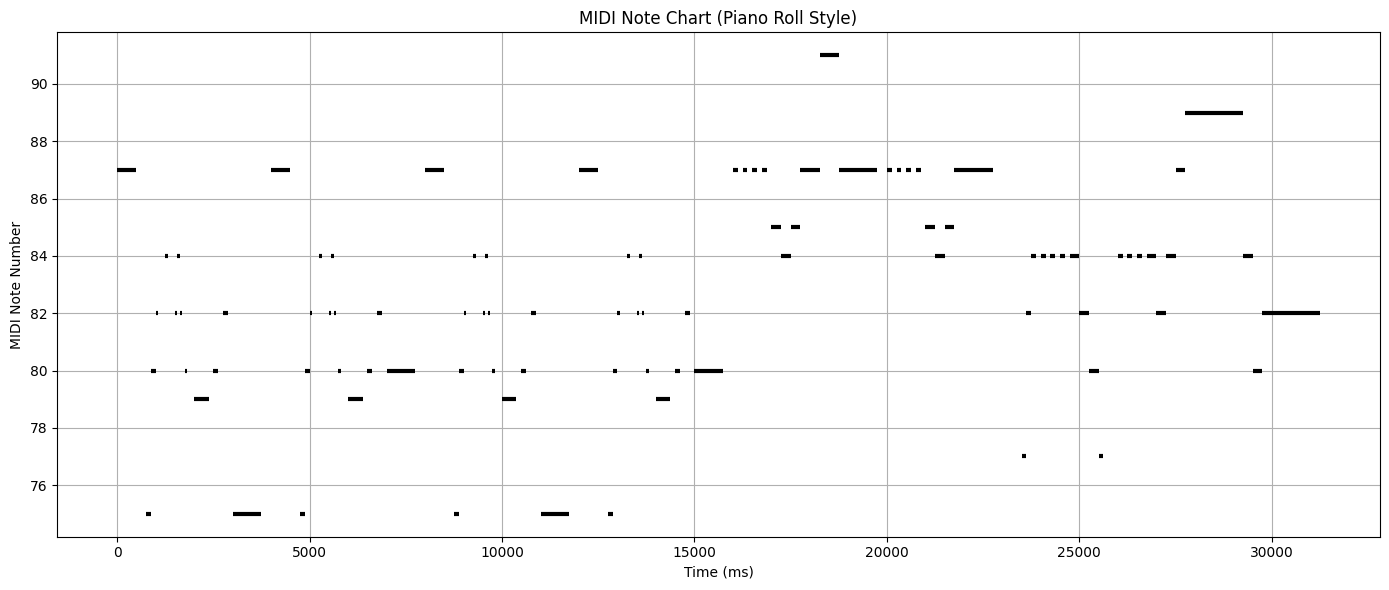

In [1]:
import mido
import matplotlib.pyplot as plt
import pandas as pd

# Load MIDI file
mid = mido.MidiFile("Shop Melody.mid")

# Extract note-on and note-off events
notes_data = []
for track in mid.tracks:
    time = 0
    ongoing_notes = {}

    for msg in track:
        time += msg.time
        if msg.type == 'note_on':
            if msg.velocity > 0:
                ongoing_notes[msg.note] = time  # Note started
            else:
                if msg.note in ongoing_notes:
                    start = ongoing_notes.pop(msg.note)
                    duration = time - start
                    notes_data.append((start, msg.note, duration))
        elif msg.type == 'note_off':
            if msg.note in ongoing_notes:
                start = ongoing_notes.pop(msg.note)
                duration = time - start
                notes_data.append((start, msg.note, duration))

# Convert to DataFrame
df = pd.DataFrame(notes_data, columns=["Start Time", "Note", "Duration"])

# MIDI note number to name
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
def note_number_to_name(n):
    return f"{note_names[n % 12]}{n // 12}"

df["Note Name"] = df["Note"].apply(note_number_to_name)

# Convert ticks to milliseconds
tick_to_ms = 500 / mid.ticks_per_beat
df["Start Time (ms)"] = df["Start Time"] * tick_to_ms
df["Duration (ms)"] = df["Duration"] * tick_to_ms
df["End Time (ms)"] = df["Start Time (ms)"] + df["Duration (ms)"]

# Sort by start time
df = df.sort_values(by="Start Time (ms)").reset_index(drop=True)

# Calculate rests between notes in 50ms units
df["Rest Before (ms)"] = df["Start Time (ms)"].diff().fillna(0)
df["Rest Before (ms)"] = df["Rest Before (ms)"] - df["Duration (ms)"].shift(1).fillna(0)
df["Rest Before (ms)"] = df["Rest Before (ms)"].apply(lambda x: max(0, x))
df["Rest Before (ms)"] = df["Rest Before (ms)"].shift(-1).fillna(0)
df["Rest Units"] = (df["Rest Before (ms)"] / 10).round().astype(int)
df["Duration Units"] = (df["Duration (ms)"] / 10).round().astype(int)

# Add frequency and period
# MIDI note to frequency: f = 440 * 2^((n - 69)/12)
df["Frequency (Hz)"] = df["Note"].apply(lambda n: 440 * 2 ** ((n - 69) / 12))
df["Period (us)"] = df["Frequency (Hz)"].apply(lambda f: round(1_000_000 / f, 5))

# Add preload value for 8051 timer (assuming 11.059200 MHz clock)
def timer_preload(frequency_hz, cpu_freq=11_059_200):
    toggle_period = 1 / (2 * frequency_hz)
    cycles = toggle_period * cpu_freq
    preload = int(65536 - cycles)
    return preload

df["Timer Preload"] = df["Frequency (Hz)"].apply(timer_preload)

# Plot horizontal bars
plt.figure(figsize=(14, 6))
for _, row in df.iterrows():
    plt.hlines(row["Note"], row["Start Time (ms)"], row["End Time (ms)"], colors='black', linewidth=3)

plt.title("MIDI Note Chart (Piano Roll Style)")
plt.xlabel("Time (ms)")
plt.ylabel("MIDI Note Number")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
df['Timer Preload (hex)'] = df['Timer Preload'].apply(lambda x: f"{x:04X}")
df['Duration Units (hex)'] = df['Duration Units'].apply(lambda x: f"{x:02X}")
df['Rest Units (hex)'] = df['Rest Units'].apply(lambda x: f"{x:02X}")


# Check if Timer Preload is within 0-65535
assert df['Timer Preload'].between(0, 65535).all(), "Timer Preload values are out of range!"

df[[
    "Note Name",
    "Timer Preload (hex)",
    "Duration Units (hex)",
    "Rest Units (hex)",
]]



,Note Name,Timer Preload (hex),Duration Units (hex),Rest Units (hex)
0,D#7,EEA4,32,19
1,D#6,DD49,0C,00
2,G#6,E5FE,0C,00
3,A#6,E8D5,06,13
4,C7,EB5C,06,13
...,...,...,...,...
86,D#7,EEA4,19,00
87,F7,F089,96,00
88,C7,EB5C,19,00
89,G#6,E5FE,19,00


In [3]:
notes_mapping = ''

for i, row in df.iterrows():
    notes_mapping += f'DB 0{row["Timer Preload (hex)"][:2]}H, 0{row["Timer Preload (hex)"][2:]}H\n'
# print(notes_mapping)
print(notes_mapping.count('\n'))

with open('notes_mapping.txt', 'w') as f:
    f.write(notes_mapping)


91


In [4]:
durations_mapping = ''

for i, row in df.iterrows():
    durations_mapping += f'DB 0{row["Duration Units (hex)"]}H, 0{row["Rest Units (hex)"]}H\n'

# print(durations_mapping)
print(durations_mapping.count('\n'))

with open('durations_mapping.txt', 'w') as f:
    f.write(durations_mapping)

91


In [114]:
# max duration
max_duration = df["Duration Units"].max()
max_duration


np.int64(150)